In [2]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
nsmc_train_df = pd.read_csv('C:/Users/bana/Desktop/전공관련파일/4-2/데이터크롤링/14/13장/ratings_train.txt', encoding='utf8', sep='\t', engine='python')
#nsmc_train_df.head()

In [3]:
nsmc_train_df = nsmc_train_df[nsmc_train_df['document'].notnull()]
#nsmc_train_df.info()
#nsmc_train_df['label'].value_counts()

In [4]:
import re
nsmc_train_df['document'] = nsmc_train_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅎ|가-힣]+', " ", x))
#nsmc_train_df.head()

In [5]:
nsmc_test_df = pd.read_csv('C:/Users/bana/Desktop/전공관련파일/4-2/데이터크롤링/14/13장/ratings_test.txt', encoding='utf8', sep='\t', engine='python')
#nsmc_test_df.head()
#nsmc_test_df.info()
nsmc_test_df = nsmc_test_df[nsmc_test_df['document'].notnull()]
nsmc_test_df['label'].value_counts()
nsmc_test_df['document'] = nsmc_test_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅎ|가-힣]+', " ", x))
#nsmc_train_df.head()

In [6]:
from konlpy.tag import Okt
okt = Okt()

In [7]:
def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, ngram_range = (1,2), min_df=3, max_df=0.9)
tfidf.fit(nsmc_train_df['document'])
nsmc_train_tfidf = tfidf.transform(nsmc_train_df['document'])

In [13]:
from sklearn.linear_model import LogisticRegression
SA_lr = LogisticRegression(random_state = 0)

In [14]:
SA_lr.fit(nsmc_train_tfidf, nsmc_train_df['label'])

LogisticRegression(random_state=0)

In [15]:
from sklearn.model_selection import GridSearchCV

params = {'C' : [1,3, 3.5, 4, 4.5, 5]}
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid = params, cv=3, scoring = 'accuracy', verbose=1)

In [17]:
SA_lr_grid_cv.fit(nsmc_train_tfidf, nsmc_train_df['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [1, 3, 3.5, 4, 4.5, 5]}, scoring='accuracy',
             verbose=1)

In [18]:
print(SA_lr_grid_cv.best_params_, round(SA_lr_grid_cv.best_score_, 4))

{'C': 5} 0.8545


In [19]:
SA_lr_best = SA_lr_grid_cv.best_estimator_

In [20]:
nsmc_test_tfidf = tfidf.transform(nsmc_test_df['document'])

In [21]:
test_predict = SA_lr_best.predict(nsmc_test_tfidf)

In [25]:
from sklearn.metrics import accuracy_score
print('감성 분석 정확도 : ', round(accuracy_score(nsmc_test_df['label'], test_predict), 3))

감성 분석 정확도 :  0.857


In [26]:
st = input("감성 분석할 문장 입력 >>")

감성 분석할 문장 입력 >>웃자 ^0^ 오늘은 좋은 날이 될거같은 예감


In [27]:
st = re.compile(r'[ㄱ-ㅎ|가-힣]+').findall(st)
print(st)
st = [" ".join(st)]
print(st)

['웃자', '오늘은', '좋은', '날이', '될거같은', '예감']
['웃자 오늘은 좋은 날이 될거같은 예감']


In [28]:
st_tfidf = tfidf.transform(st)
st_predict = SA_lr_best.predict(st_tfidf)

In [29]:
if(st_predict == 0):
    print(st , "-> 부정 감성")
else:
    print(st , "-> 긍정 감성")

['웃자 오늘은 좋은 날이 될거같은 예감'] -> 긍정 감성


In [30]:
#파일 오픈
import json

file_name = '취업_naver_news'
url = 'C:/Users/bana/Desktop/전공관련파일/4-2/데이터크롤링/기말/' + file_name + '.json'
with open(url , encoding='utf8') as j_f:
    data= json.load(j_f)


#제목과 내용으로 분리
data_title = []
data_description = []

for item in data:
    data_title.append(item['title'])
    data_description.append(item['description'])



#dataframe으로 변환
import pandas as pd
data_df = pd.DataFrame({'title':data_title, 'description':data_description})


#전처리
import re
data_df['title'] = data_df['title'].apply(lambda x : re.sub(r'[^ ㄱ-ㅎ|가-힣]', " ", x))
data_df['description'] = data_df['description'].apply(lambda x : re.sub(r'[^ ㄱ-ㅎ|가-힣]', " ", x))

data_df.head()

,title,description
0,국민의힘 김건희 연수 이력 허위 의혹 제기 고발 방침,김병기 현안대응 단장은 김씨가 주장한 스턴 스쿨 연수 과정은 허위일 가...
1,구직 구인자 만남의 장 중구 일자리 박람회 개최,이번 박람회는 단계적 일상회복에 맞춰 코로나 로 얼어붙은 취업 시장을...
2,최태원 동생 최재원 수석부회장 온 대표로 년만에 경영 복귀,이후 년 월 가석방된 뒤 취업 제한을 적용받다 월 말 ...
3,춘해보건대 대학방사선사협회와 지방연수원 개설 업무협약 체결,감사말씀을 드린다 며 업무 협약을 통해 지방연수원뿐만 아니라 방...
4,코로나 고용충격 일용직 근로자 개월째 감소,통계청 고용동향에 따르면 지난달 취업 자 중 일용직 근로자는 만 ...


In [31]:
data_title_tfidf = tfidf.transform(data_df['title'])

data_title_predict = SA_lr_best.predict(data_title_tfidf)

data_df['title_label'] = data_title_predict

In [32]:
data_description_tfidf = tfidf.transform(data_df['description'])

data_description_predict = SA_lr_best.predict(data_description_tfidf)

data_df['description_label'] = data_description_predict

In [36]:
#data_df.head()
print(data_df['title_label'].value_counts())
print()
print(data_df['description_label'].value_counts())

0    522
1    478
Name: title_label, dtype: int64

1    520
0    480
Name: description_label, dtype: int64


In [41]:
columns_name = ['title', 'title_label', 'description', 'description_label']
NEG_data_df = pd.DataFrame(columns = columns_name)
POS_data_df = pd.DataFrame(columns = columns_name)

for i, data in data_df.iterrows():
    title = data["title"]
    description = data["description"]
    t_label = data["title_label"]
    d_label = data["description_label"]
    
    if(d_label == 0): #제목은 무시하고, 내용이 부정감성인것만 추출
        NEG_data_df = NEG_data_df.append(pd.DataFrame([[title, t_label, description, d_label]], columns = columns_name), ignore_index = True)
    else:
        POS_data_df = POS_data_df.append(pd.DataFrame([[title, t_label, description, d_label]], columns = columns_name), ignore_index = True)

filename = '취업감성분류'
NEG_data_df.to_csv("C:/Users/bana/Desktop/전공관련파일/4-2/데이터크롤링/14/13장/"+filename+'_NEG.csv', encoding='euc-kr')
POS_data_df.to_csv("C:/Users/bana/Desktop/전공관련파일/4-2/데이터크롤링/14/13장/"+filename+'_POS.csv', encoding='euc-kr')

In [42]:
POS_description = POS_data_df['description']

In [43]:
POS_description_noun_tk = []
for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d))

In [45]:
#print(POS_description_noun_tk)

In [46]:
POS_description_noun_join = []
for d in POS_description_noun_tk:
    d2 = [w for w in d if len(w) > 1]
    POS_description_noun_join.append(" ".join(d2))

In [48]:
#print(POS_description_noun_join)

In [50]:
NEG_description = NEG_data_df['description']
NEG_description_noun_tk = []
for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d))
NEG_description_noun_join = []
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1]
    NEG_description_noun_join.append(" ".join(d2))
    
#print(NEG_description_noun_join)

In [55]:
POS_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df = 2)
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

In [58]:
POS_vocab = dict()
for idx, word in enumerate(POS_tfidf.get_feature_names()):
    POS_vocab[word] = POS_dtm.getcol(idx).sum()
POS_words = sorted(POS_vocab.items(), key=lambda x: x[1], reverse=True)

In [60]:
#POS_words

In [62]:
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df = 2)
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)
NEG_vocab = dict()
for idx, word in enumerate(NEG_tfidf.get_feature_names()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
NEG_words = sorted(NEG_vocab.items(), key=lambda x: x[1], reverse=True)
#NEG_words

In [63]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family = font_name)

max=15

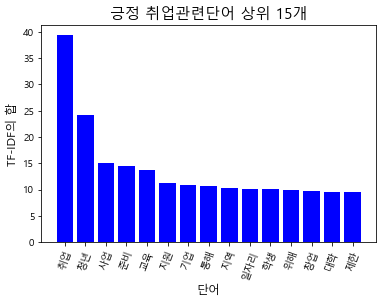

In [66]:
plt.bar(range(max), [i[1] for i in POS_words[:max]], color="blue")
plt.title("긍정 취업관련단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation=70)
plt.show()

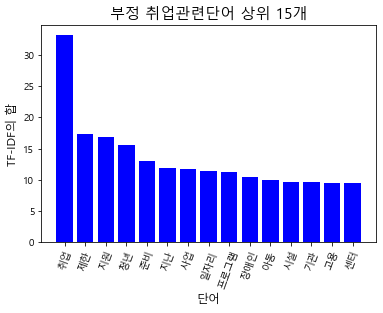

In [67]:
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color="blue")
plt.title("부정 취업관련단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in NEG_words[:max]], rotation=70)
plt.show()